In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [27]:
# load the dataset
df = pd.read_csv('train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [28]:
# function for heading
def heading(text):
    print(f"{'*' * len(text)}")
    print(text.upper())
    print(f"{'*' * len(text)}")


    # print("*" * len(text))
    # print(text.upper())
    # print("*" * len(text))

In [29]:
heading("number of rows and columns")
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

**************************
NUMBER OF ROWS AND COLUMNS
**************************
Number of Rows: 8523
Number of Columns: 12


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [31]:
heading("categorical columns")
categorical_columns = df.select_dtypes(include=['O']).columns.tolist()
number_of_categorical_columns = len(categorical_columns)
print(f"Number of Categorical Columns: {number_of_categorical_columns}")
print(f"Categorical Columns: {categorical_columns}")


heading("numerical columns")
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
number_of_numerical_columns = len(numerical_columns)
print(f"Number of Numerical Columns: {number_of_numerical_columns}")
print(f"Numerical Columns: {numerical_columns}")

*******************
CATEGORICAL COLUMNS
*******************
Number of Categorical Columns: 7
Categorical Columns: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
*****************
NUMERICAL COLUMNS
*****************
Number of Numerical Columns: 5
Numerical Columns: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']


In [32]:
# checking for missing values
df.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Weight                  1463
Item_Fat_Content                0
Item_Identifier                 0
Item_Visibility                 0
Item_Type                       0
Outlet_Identifier               0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

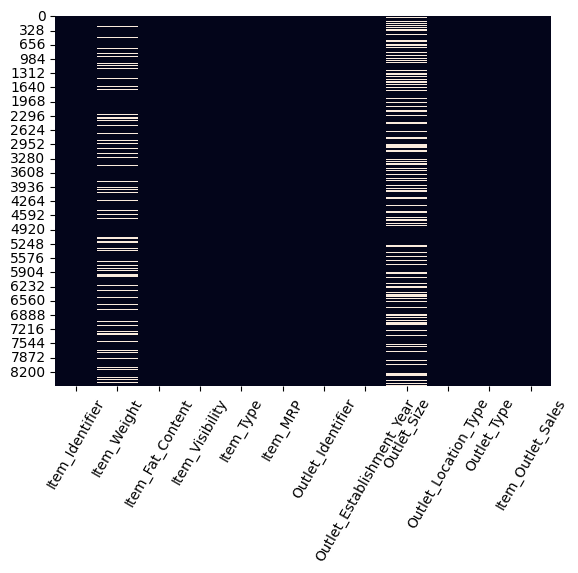

In [33]:
sns.heatmap(df.isnull(), cbar=False)
plt.xticks(rotation=60)
plt.show()

<Axes: >

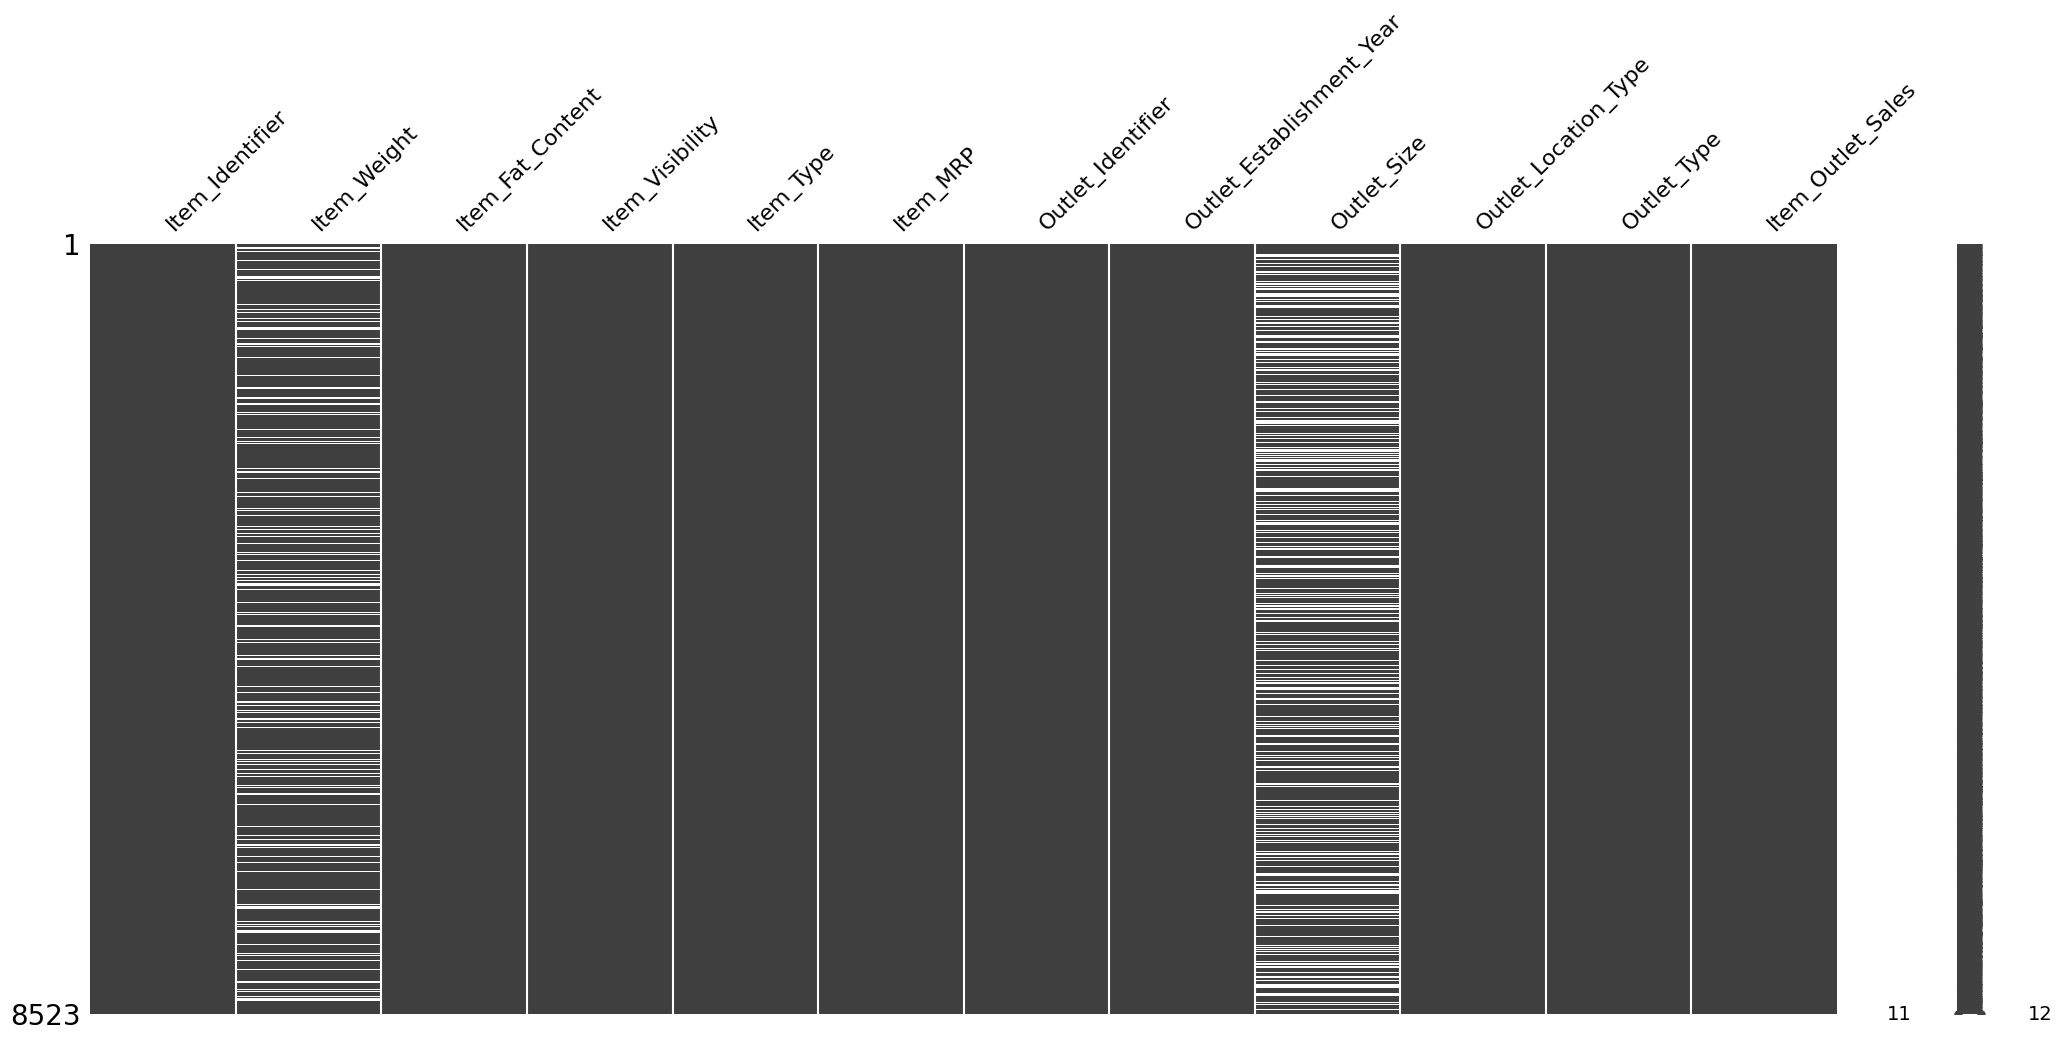

In [34]:
import missingno as msno
msno.matrix(df)

### As `Item_Weight` is a numerical and `Outlet_Size` is categorical column, we will impute the missing values of `Item_Weight` with **mean** and `Outlet_Size` with **mode**

In [35]:
df['Item_Weight'].mean()

np.float64(12.857645184135976)

In [36]:
# filling missing values
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)
df.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Identifier                 0
Item_Fat_Content                0
Item_Weight                     0
Item_Visibility                 0
Item_Type                       0
Outlet_Identifier               0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [37]:
mode_of_Outlet_size = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
mode_of_Outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [38]:
miss_values = df['Outlet_Size'].isnull()   

In [39]:
# fill the other missing values
df.loc[miss_values, 'Outlet_Size'] = df.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

<Axes: >

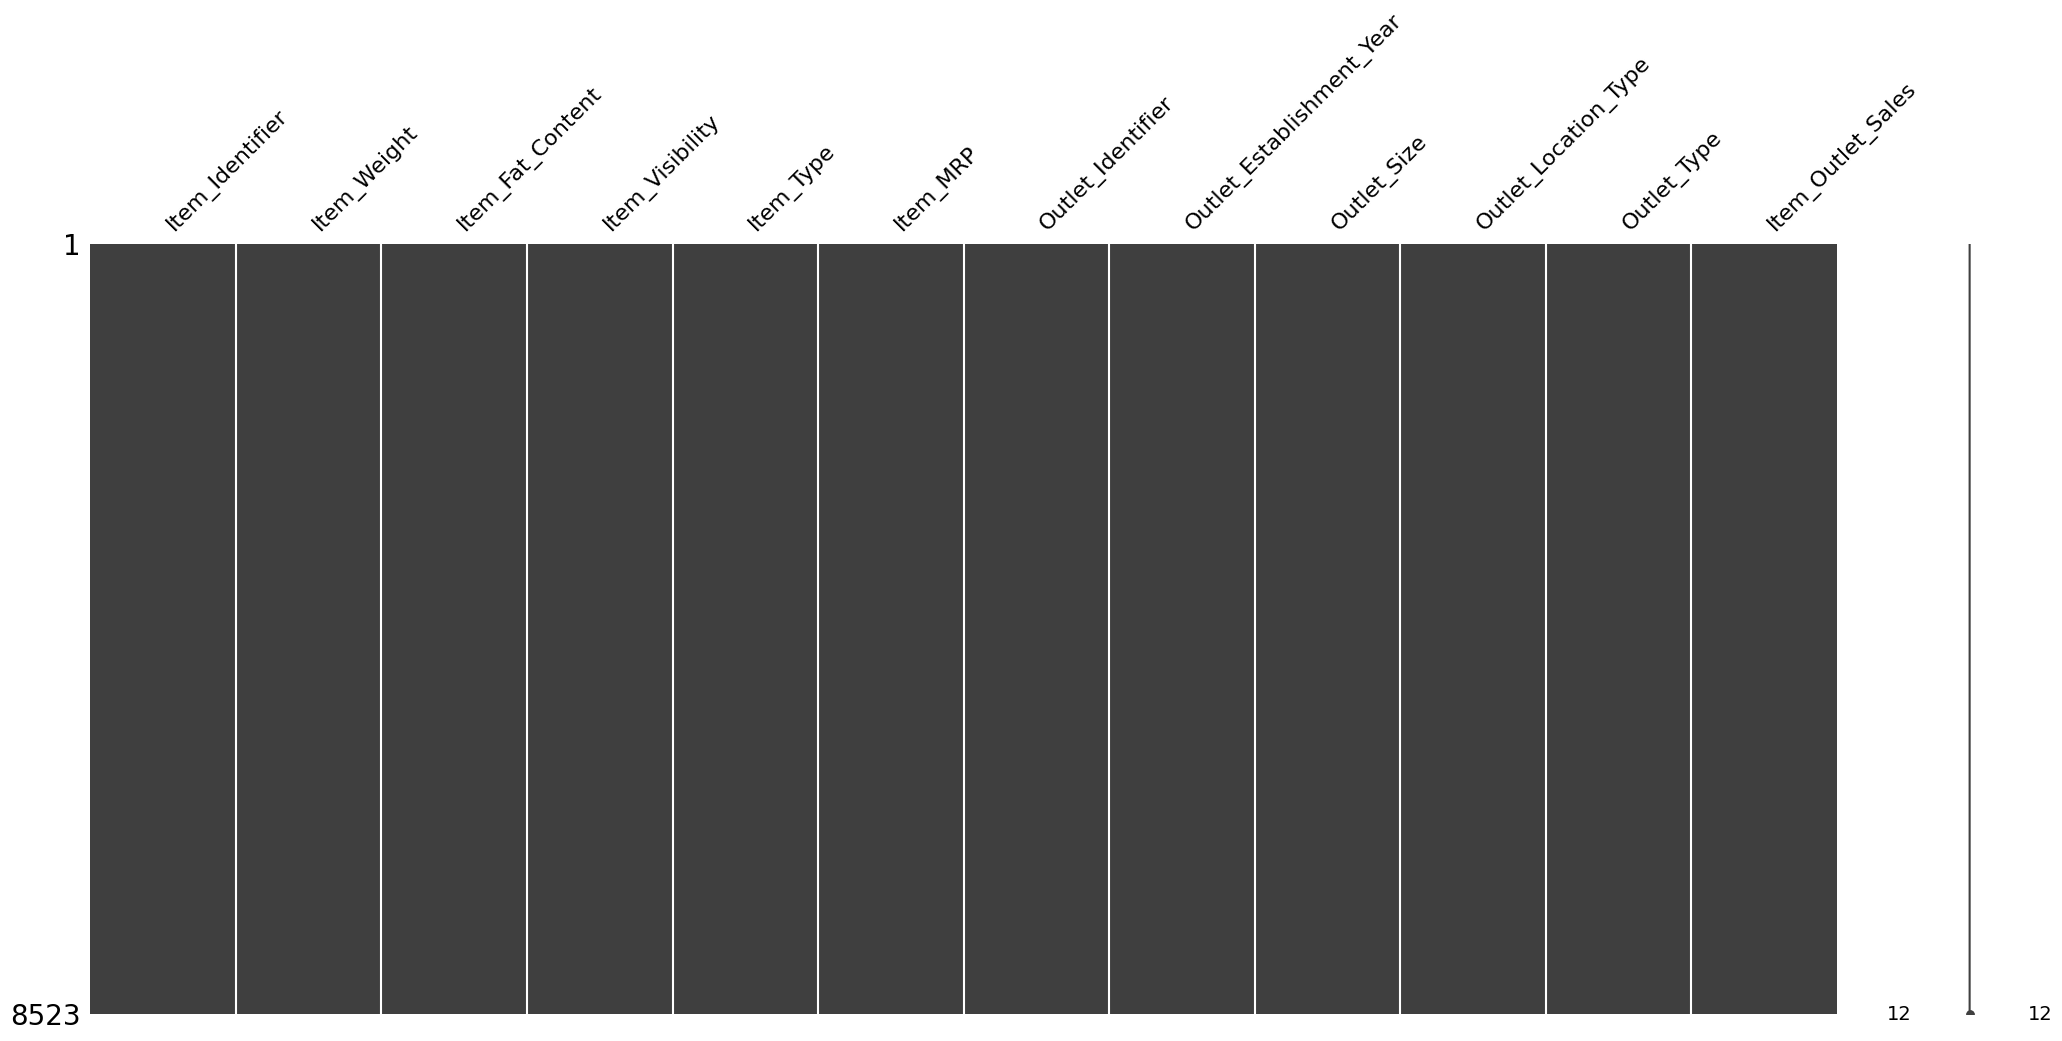

In [40]:
msno.matrix(df)

In [41]:
# statictical analysis
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,8523.0,12.857645,4.226124,4.555,9.310000,12.857645,16.000000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


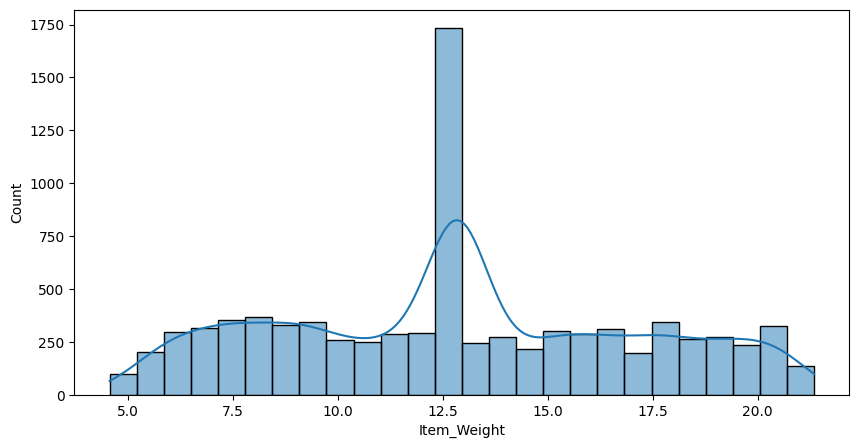

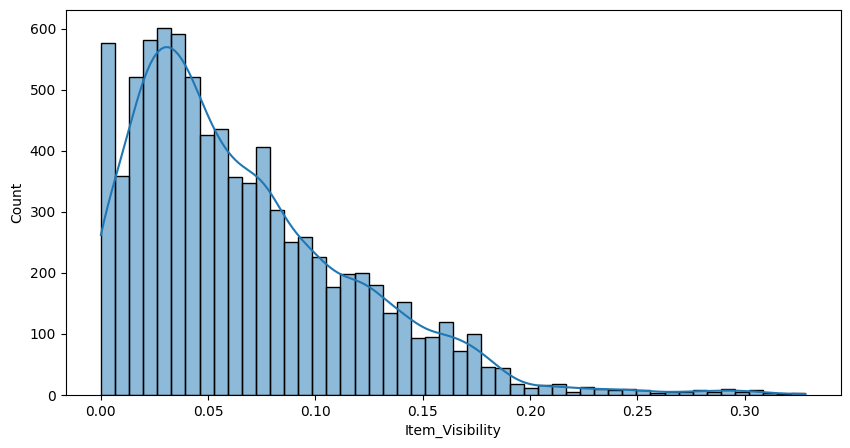

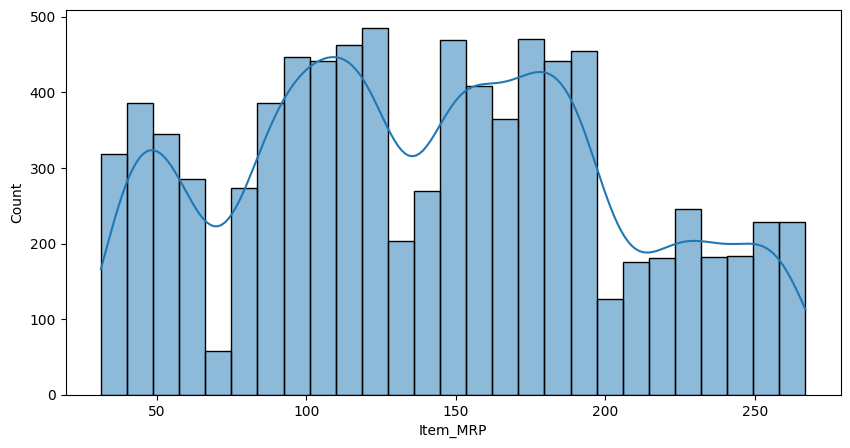

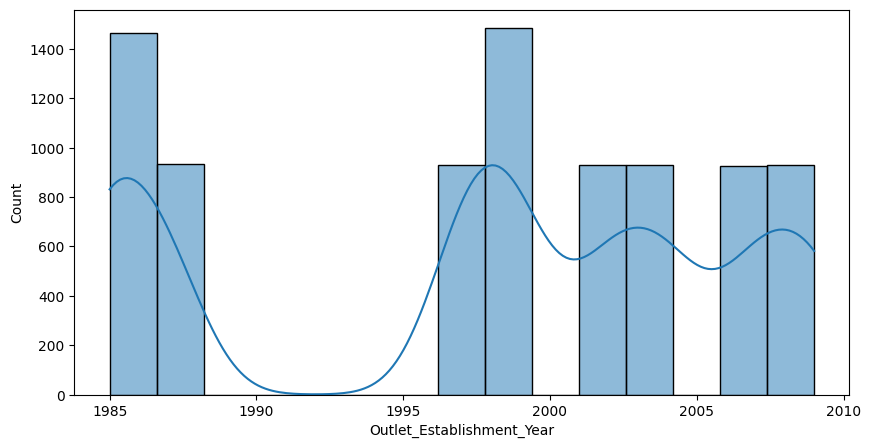

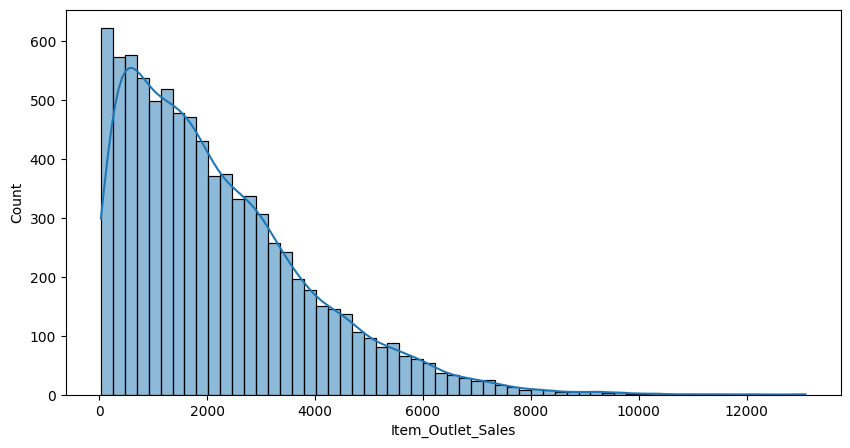

In [42]:
# distribution for all numerical columns
for col in numerical_columns:
    plt.figure(figsize=(10,5))
    sns.histplot(df[col], kde=True)
    plt.show()

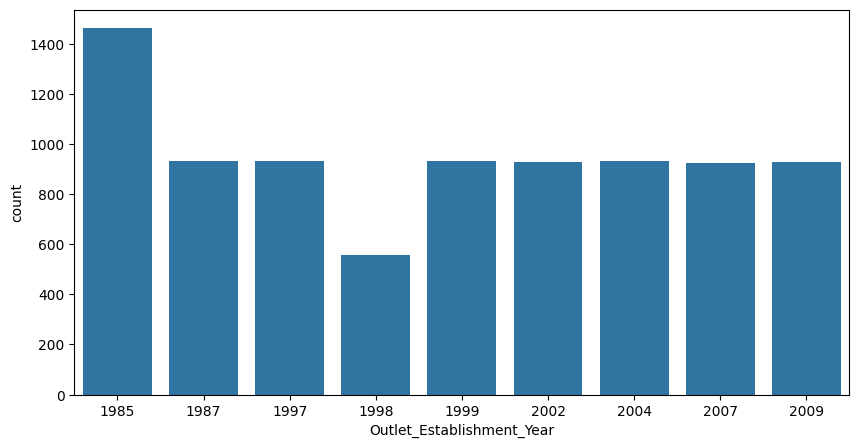

In [43]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Outlet_Establishment_Year')
plt.show()

In [44]:
# same plot using plotly
import plotly.express as px
fig = px.histogram(df, x='Outlet_Establishment_Year')
fig.show()

In [45]:
# Item_Fat_Content Column
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

#### We just make 2 categories

In [46]:
df.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

### Encoding the categorical columns

In [47]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [48]:
# using encoder for Item_Fat_Content
le = LabelEncoder()
df['Item_Identifier'] = le.fit_transform(df['Item_Identifier'])
df['Item_Fat_Content'] = le.fit_transform(df['Item_Fat_Content'])
df['Item_Type'] = le.fit_transform(df['Item_Type'])
df['Outlet_Identifier'] = le.fit_transform(df['Outlet_Identifier'])
df['Outlet_Size'] = le.fit_transform(df['Outlet_Size'])
df['Outlet_Location_Type'] = le.fit_transform(df['Outlet_Location_Type'])
df['Outlet_Type'] = le.fit_transform(df['Outlet_Type'])

In [49]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


### Train and Test Split

In [50]:
X = df.drop('Item_Outlet_Sales', axis=1)
Y = df['Item_Outlet_Sales']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Model Training

In [51]:
regressor = XGBRegressor()
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [52]:
# predicting on training data
training_data_prediction = regressor.predict(X_train)
r2_train = metrics.r2_score(Y_train, training_data_prediction)
print("R Square on Training Data: ", r2_train)

R Square on Training Data:  0.8767038065269914


In [53]:
# predicting on test data
test_data_prediction = regressor.predict(X_test)
r2_test = metrics.r2_score(Y_test, test_data_prediction)
print("R Square on Test Data: ", r2_test)

R Square on Test Data:  0.524872071316624


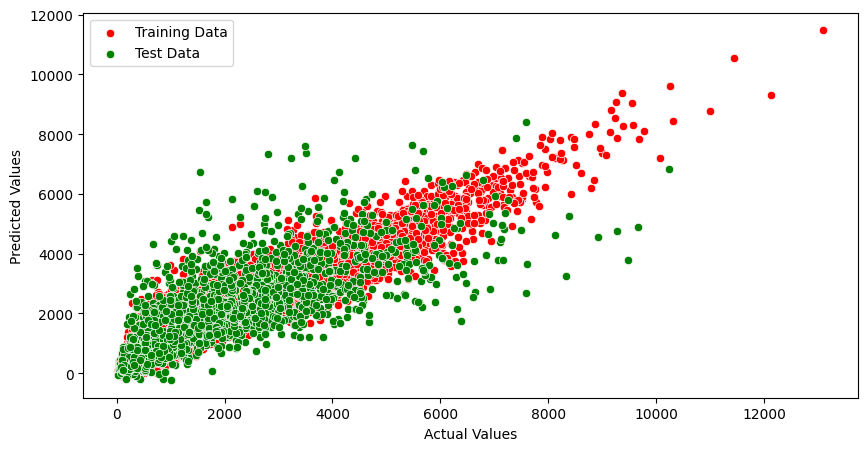

In [56]:
# drawing scatter plot with different colors
plt.figure(figsize=(10,5))
sns.scatterplot(x=Y_train, y=training_data_prediction, color='red')
sns.scatterplot(x=Y_test, y=test_data_prediction, color='green')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend(["Training Data", "Test Data"])
plt.show()

In [59]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


In [65]:
# now make a prediction
Item_Identifier = 156
Item_Weight = 9.30
Item_Fat_Content = 0
Item_Visibility = 0.016047
Item_Type = 4
Item_MRP = 249.8092
Outlet_Identifier = 9
Outlet_Size = 1
Outlet_Location_Type = 0
Outlet_Type = 1

prediction = regressor.predict([[Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Identifier, Outlet_Size, Outlet_Location_Type, Outlet_Type, 2]])
print("Predicted Sales: ", prediction[0])

Predicted Sales:  6435.9756


In [ ]:
# # now make a prediction
# input_data = (0, 9.30, 0, 0.016047, 4, 249.8092)



# input_data_as_numpy_array = np.asarray(input_data)
# input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)
# prediction = regressor.predict(input_data_reshaped)
# print("Predicted Item_Outlet_Sales: ", prediction)